In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from quickdraw import QuickDrawDataGroup
from libs import nb_utils, utils, dataset_utils
from cppn import CPPN

print(tf.__version__)

1.13.1


In [2]:
#
# Note: Downloads a huge data set.
#
#
'''total_drawings = 121380
balloons = QuickDrawDataGroup("hot air balloon", max_drawings=total_drawings, refresh_data=True, print_messages =True)
for i in range(total_drawings):
    balloon = balloons.get_drawing(i)
    balloon.image.save("data/balloon/balloon_"+str(i)+".gif")'''


'total_drawings = 121380\nballoons = QuickDrawDataGroup("hot air balloon", max_drawings=total_drawings, refresh_data=True, print_messages =True)\nfor i in range(total_drawings):\n    balloon = balloons.get_drawing(i)\n    balloon.image.save("data/balloon/balloon_"+str(i)+".gif")'

data/balloon/balloon_0.gif


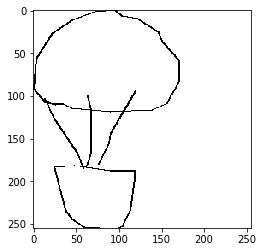

In [3]:
files = sorted([os.path.join('data/balloon/', f) for f in os.listdir('data/balloon/')])
print(files[0])
plt.imshow(plt.imread(files[0]))

In [4]:
tf.reset_default_graph()

batch_size=100
n_pixels=32
n_channels=3
input_shape=[None, n_pixels, n_pixels, n_channels]
z_dim=32

X = tf.placeholder(name='X', shape=input_shape, dtype=tf.float32)

In [5]:
#Used by the discriminator. Creates the latent vector
def encoder(x, channels=[50, 50, 50 ,50, 1], filter_sizes=[4, 4, 4, 4, 4], activation=tf.tanh, reuse=None):
    h=x
    hs=[]
    
    for layer_i in range(len(channels)):
        with tf.variable_scope('layer{}'.format(layer_i+1), reuse=reuse):
            h,W = utils.conv2d(x, n_output=channels[layer_i], k_h=filter_sizes[layer_i], k_w=filter_sizes[layer_i], reuse=reuse)
            h = activation(h)
            hs.append(h)
    return h, hs

def discriminator(x, channels=[50, 50, 50 ,50, 1], filter_sizes=[4, 4, 4, 4, 4], activation=utils.lrelu, reuse=None):
    h=None
    with tf.variable_scope('discriminator', reuse=reuse):
        h, hs = encoder(x, channels, filter_sizes, activation, reuse=reuse)
        shape = h.get_shape().as_list()
        #h = tf.reshape(h, [-1, shape[1]*shape[2]*shape[3]])
        
        D,W = utils.linear(x, activation=tf.sigmoid, n_output=1, reuse=reuse)
    return D, h

In [6]:
D_real, z = discriminator(X)
print(z.shape)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
(?, 16, 16, 1)


In [7]:
#z_dim=32

def generator(z, x_y_dim=n_pixels, channels=[256, 256, 256, n_channels], activation=tf.tanh, reuse=None):
    with tf.variable_scope('generator'):
        g = CPPN(width=x_y_dim, height=x_y_dim,z=z, channels=n_channels, hidden_neurons=channels[0])
        G = g.generate()
        shape = G.get_shape().as_list()
        G = tf.reshape(G,[1, shape[0], shape[1], shape[2]])
    return G
    

In [8]:
#Get the first sample
G = generator(z, reuse=True)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use keras.layers.flatten instead.


In [9]:
D_fake, z_fake=discriminator(G, reuse=True)
D_fake

<tf.Tensor 'discriminator_1/fc/Sigmoid:0' shape=(1, 1) dtype=float32>

In [10]:
with tf.variable_scope('loss/generator'):
    loss_G = tf.reduce_mean(utils.binary_cross_entropy(D_fake, tf.ones_like(D_fake)))
with tf.variable_scope('loss/discriminator/real'):
    loss_D_real = utils.binary_cross_entropy(D_real, tf.ones_like(D_real))
with tf.variable_scope('loss/discriminator/fake'):
    loss_D_fake = utils.binary_cross_entropy(D_fake, tf.ones_like(D_fake))
with tf.variable_scope('loss/discriminator'):
    loss_D = tf.reduce_mean((loss_D_real + loss_D_fake) / 2)

In [11]:
graph = tf.get_default_graph()
#nb_utils.show_graph(graph.as_graph_def())

In [12]:
vars_d = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
vars_g = [v for v in tf.trainable_variables() if v.name.startswith('generator')]

d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

In [13]:
learning_rate = 0.0001

lr_g = tf.placeholder(tf.float32, shape=[], name='learning_rate_g')
lr_d = tf.placeholder(tf.float32, shape=[], name='learning_rate_d')

In [14]:
opt_g = tf.train.AdamOptimizer(learning_rate=lr_g).minimize(loss_G + g_reg, var_list=vars_g)
opt_d = tf.train.AdamOptimizer(learning_rate=lr_d).minimize(loss_D + d_reg, var_list=vars_d)

In [15]:
batch_size = 64
n_epochs = 1
crop_shape = [n_pixels, n_pixels, 1]
crop_factor = 0.8
input_shape = [255, 255, 3]

batch = dataset_utils.create_input_pipeline(
            files=files,
            batch_size = batch_size,
            n_epochs=n_epochs,
            crop_shape = crop_shape,
            crop_factor=crop_factor,
            shape=input_shape)


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset

In [16]:
equilibrium = 0.693
margin = 0.2

In [17]:
batch

<tf.Tensor 'shuffle_batch:0' shape=(64, 32, 32, 3) dtype=float32>

In [ ]:
ckpt_name = './gan.ckpt'



with tf.device('/device:GPU:0'):
# with tf.device('/CPU'):
    config = tf.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    tf.get_default_graph().finalize()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

#     if os.path.exists(ckpt_name+'.index') or os.path.exists(ckpt_name):
#         saver.restore(sess, ckpt_name)
#         print('Model restored')
        
    t_i = 0
    batch_i = 0
    epoch_i = 0
    n_files = len(files)
    
    if not os.path.exists('imgs'):
        os.makedirs('imgs')
        
    while epoch_i < n_epochs:
        batch_i += 1
        batch_xs = sess.run(batch) / 255.0
        #batch_zs = np.random.uniform(0,0, 1.0, [batch_size, z_dim]).astype(np.float32)
        
        real_cost, fake_cost = sess.run([loss_D_real, loss_D_fake],
                                       feed_dict = {
                                            X:batch_xs
                                        })
        real_cost = np.mean(real_cost)
        fake_cost = np.mean(fake_cost)
        
        if(batch_i%20) == 0:
            print(batch_i, 'real:', real_cost, '/ fake:', fake_cost)
            
        gen_update = True
        dis_update = True
        
        if real_cost > (equilibrium + margin) or fake_cost > (equilibrium + margin):
            gen_update = False
        
        if real_cost < (equilibrium - margin) or fake_cost < (equilibrium-+ margin):
            dis_update = False
            
        if not (gen_update or dis_update):
            gen_update = True
            dis_update = True
        
        if dis_update:
            sess.run(opt_d, feed_dict={X:batch_xs, lr_d: learning_rate})
        
        if gen_update:
            sess.run(opt_g, feed_dict={lr_g: learning_rate})
            
        if batch_i % (n_files // batch_size) == 0:
            batch_i = 0
            epoch_i += 1
            print('--------------------------EPOCH: ',epoch_i)
            
            recon = sess.run(G)
            
            recon = np.clip(recon, 0, 1)
            m1 = utils.montage(recon.reshape([-1]+crop_shape), 'imgs/manifold_%08d.png' % t_i)
            
            recon = sess.run(G)
            m2 = utils.montage(recon.reshape([-1]+crop_shape), 'imgs/reconstructions_%08d.png' % t_i)
            
            fig, axs = plt.subplots(1,2,figsize(15,10))
            axs[0].imshow(m1)
            axs[0].imshow(m2)
            plt.show()
            t_i+=1
            
            with tf.device('/CPU'):
                saver = tf.train.Saver()
                save_path = saver.save(sess, './'+ckpt_name, global_step=batch_i, write_meta_graph=False)
                print('Model saved in file: %s' % save_path)
    coord.request_stop()
    coord.join(threads)
    sess.close()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
20 real: 0.42591164 / fake: 0.10008892
40 real: 0.43337715 / fake: 0.051250957
60 real: 0.41779014 / fake: 0.03464887
80 real: 0.43295872 / fake: 0.027780743
100 real: 0.4297492 / fake: 0.024199553
120 real: 0.42400184 / fake: 0.021196146
140 real: 0.43332922 / fake: 0.018703053
160 real: 0.43043366 / fake: 0.015836885
180 real: 0.4295358 / fake: 0.013333665
200 real: 0.4196084 / fake: 0.011945622
220 real: 0.43321818 / fake: 0.01091087
240 real: 0.42321563 / fake: 0.010196278
260 real: 0.43015134 / fake: 0.009553323
280 real: 0.42357284 / fake: 0.008928161
300 real: 0.42402142 / fake: 0.008371247
320 real: 0.4393357 / fake: 0.0078046108
340 real: 0.4302498 / fake: 0.0073209708
360 real: 0.43375748 / fake: 0.006923868
380 real: 0.43077824 / fake: 0.0064231963
400 real: 0.43367335 / fake: 0.0060581714
420 real: 0.4296295 / fake: 0.0058333813
440 real: 0.4250679 / fake: 0.005647663
460 real: 0.42761415 / f